In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from train import create_model, create_criterion, evaluate
from dataset import TrainData, TrainDataset

In [2]:
input_dir = "/storage/kaggle/quickdraw"
model_type = "cnn"
model_name = "cnn"
loss_type = "cce"
image_size = 32
batch_size = 64
test_size = 0.1
train_on_unrecognized = True
num_category_shards = 1
category_shard = 0
num_categories = 340 // num_category_shards
num_workers = 8
pin_memory = True
use_dummy_image = False
predict_on_val_set = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = create_model(model_type, input_size=image_size, num_classes=num_categories)
model.load_state_dict(torch.load("/storage/models/quickdraw/{}/model.pth".format(model_name), map_location=device))

In [5]:
train_data = TrainData(
    input_dir,
    shard=0,
    test_size=test_size,
    train_on_unrecognized=train_on_unrecognized,
    num_category_shards=num_category_shards,
    category_shard=category_shard)

Reading data file '/storage/kaggle/quickdraw/train_simplified_shards/shard-0.npz'
Loaded 994325 samples
Time to load data of shard 0: 0:00:26.288364


In [6]:
val_set = TrainDataset(train_data.val_set_df, image_size, use_dummy_image)
val_set_data_loader = \
    DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [7]:
criterion = create_criterion(loss_type, num_categories)

In [8]:
if predict_on_val_set:
    loss_avg, mapk_avg, accuracy_top1_avg, accuracy_top3_avg, accuracy_top5_avg, accuracy_top10_avg = \
        evaluate(model, val_set_data_loader, criterion, 3)

    print(
        "loss: {:.3f}, map@3: {:.3f}, acc@1: {:.3f}, acc@3: {:.3f}, acc@5: {:.3f}, acc@10: {:.3f}"
        .format(loss_avg, mapk_avg, accuracy_top1_avg, accuracy_top3_avg, accuracy_top5_avg, accuracy_top10_avg))

In [9]:
confusion = np.zeros((num_categories, num_categories), dtype=np.float32)

for batch in tqdm(val_set_data_loader, total=len(val_set_data_loader)):
    images, categories = \
        batch[0].to(device, non_blocking=True), \
        batch[1].to(device, non_blocking=True)

    prediction_logits = model(images)
    predictions = F.softmax(prediction_logits, dim=1)
    prediction_scores, prediction_categories = predictions.topk(3, dim=1, sorted=True)

    for bpc, bc in zip(prediction_categories[:, 0], categories):
        confusion[bpc, bc] += 1

for c in range(confusion.shape[0]):
    category_count = confusion[c, :].sum()
    confusion[c, :] /= category_count

100%|██████████| 1554/1554 [00:14<00:00, 106.78it/s]


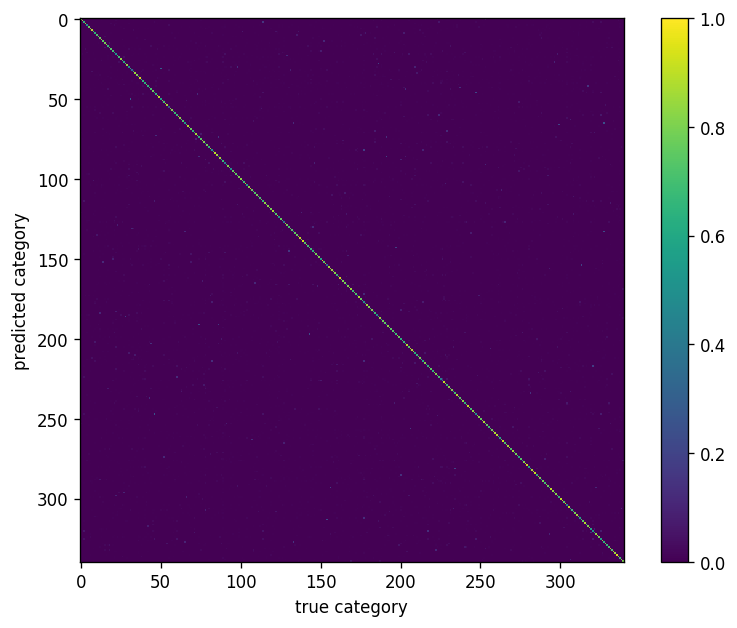

In [10]:
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor="w", edgecolor="k")
plt.imshow(confusion, vmin=0.0, vmax=1.0)
plt.xlabel("true category")
plt.ylabel("predicted category")
plt.colorbar()

In [11]:
precisions = np.array([confusion[c, c] for c in range(confusion.shape[0])])
percentiles = np.percentile(precisions, q=np.linspace(0, 100, 10))
print(percentiles)

[0.28930819 0.60283413 0.6608279  0.69999999 0.73931571 0.77172339
 0.80620158 0.8319207  0.87350068 0.94285715]


In [32]:
precisions.mean()

0.7415305

In [38]:
precisions[precisions > np.percentile(precisions, q=70)].mean()

0.8644561

In [39]:
np.array(train_data.categories)[precisions > np.percentile(precisions, q=70)]

array(['alarm clock', 'angel', 'anvil', 'apple', 'bandage',
       'baseball bat', 'bee', 'binoculars', 'book', 'bowtie', 'butterfly',
       'cactus', 'camel', 'camera', 'carrot', 'castle', 'chair', 'clock',
       'computer', 'crab', 'crown', 'cruise ship', 'diamond', 'donut',
       'drill', 'ear', 'envelope', 'eye', 'eyeglasses', 'fish',
       'flashlight', 'flower', 'fork', 'giraffe', 'hand', 'harp',
       'headphones', 'helicopter', 'hourglass', 'house plant',
       'ice cream', 'jacket', 'jail', 'key', 'ladder', 'lighthouse',
       'lightning', 'lollipop', 'megaphone', 'mountain', 'mushroom',
       'octopus', 'palm tree', 'pants', 'paper clip', 'parachute',
       'pineapple', 'popsicle', 'postcard', 'power outlet', 'rain',
       'rainbow', 'rhinoceros', 'rollerskates', 'sailboat', 'saw',
       'scissors', 'scorpion', 'see saw', 'sink', 'skateboard', 'skull',
       'snail', 'snorkel', 'snowflake', 'snowman', 'sock', 'stairs',
       'star', 'stethoscope', 'stitches', 'st